In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Load Real Data

In [2]:
path = "C:/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt").values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt").values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt").values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [3]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])


HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [13]:
# SMOOTHING
BP_data_scaled_averaged = BP_data_scaled.rolling(50).mean()
HR_data_scaled_averaged = HR_data_scaled.rolling(50).mean()

# Loading Model

In [5]:
bs = 64
lr = 0.01
stdev = 0.1
e = 20

original_dim = 32
input_shape = (original_dim, )
intermediate_dim = 16
latent_dim = 8

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=stdev)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# ENCODER
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = BatchNormalization()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()

encoder.load_weights("encoder/")

# Generate Baseline Data

In [6]:
def generate_line(a, b, n=32, noise=0):
    x = np.arange(n)
    return a * x + b + np.random.normal(0, noise, n)

def generate_lines(a, bs, n_train, c, lines, labels):
    for b in bs:
        generated_lines = np.array([generate_line(a, b, noise=0.005) for _ in range(int(n_train/16))])
        generated_labels = np.array([c for _ in range(int(n_train/16))])
        if lines.size == 0:
            lines = generated_lines
            labels = generated_labels
        else:
            lines = np.concatenate((lines, generated_lines))
            labels = np.concatenate((labels, generated_labels))
    return lines, labels
    
def generate_lines_set(n_train):    
    lines = np.array([])
    labels = np.array([])

    lines, labels = generate_lines(0, [0, .4, .8, 1.2, 1.6, 2], n_train, 'g', lines, labels)
    lines, labels = generate_lines(0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'r', lines, labels)
    lines, labels = generate_lines(-0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'b', lines, labels)

    return np.array(lines), np.array(labels)

n_lines = 64000
n_types = 16
x_train, y_train = generate_lines_set(64000)

# Calculate Baseline

In [7]:
z_test, _, _ = encoder.predict(x_train, batch_size=bs)
straight_lines_8D = z_test[:24000]
means = straight_lines_8D.mean(axis=0)
principal_axis = np.linalg.svd(straight_lines_8D - means)[2][0]
baseline_point1 = np.array([0,0,0,0,0,0,0,0], np.float32)
baseline_point2 = np.array(principal_axis, np.float32)

In [8]:
def dist(p, q, rs):
    x = p-q
    return np.linalg.norm(
        np.outer(np.dot(rs-q, x)/np.dot(x, x), x)+q-rs,
        axis=1)

# Visualize 2D

# Real Time Faints Prediction

In [9]:
def sample_timeseries(x):
    x = np.array(x)
    x = x[~np.isnan(x)]
    if x.shape[0] % 32 != 0:
        x = x[:-(x.shape[0] % 32)]
    return np.array(np.array_split(x, int(len(x)/32)))

In [10]:
# liczyc srednia rkoczaca n-elementowa i sprawdzac czy ona wykracza poza threshold i czy aktualny element wyrkacza, jesli oba 
# to czerwien jesli jedno to zolty
severity_acc = np.array([0,0,0,0,0])

def check_severity(HR_line_8D, BP_line_8D):
    global severity_acc
    distance = sum(dist(baseline_point1, baseline_point2, np.array([BP_line_8D[0], HR_line_8D[0]])))
    severity_acc = np.append(severity_acc, distance)
    averaged_distance = severity_acc[-5:].mean()
    anomaly_score = 0
    if distance > 0.11:
        anomaly_score += 2
    elif distance > 0.08:
        anomaly_score += 1
    if averaged_distance > 0.07:
        anomaly_score += 2
    elif averaged_distance > 0.06:
        anomaly_score += 1
    
    if anomaly_score > 2:
        return 'r'
    elif anomaly_score == 2:
        return 'orange'
    elif anomaly_score == 1:
        return 'y'
    else:
        return 'g'

<IPython.core.display.Javascript object>


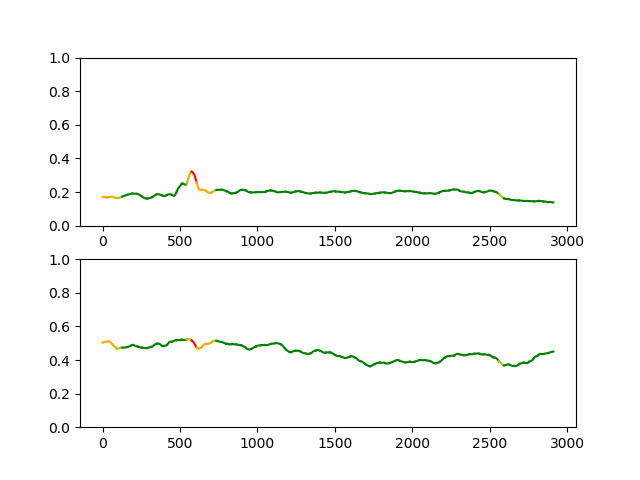

In [15]:
%matplotlib notebook
plt.ion()

n = '320'
HR = sample_timeseries(HR_data_scaled_averaged[n])
BP = sample_timeseries(BP_data_scaled_averaged[n])

# pca = PCA(n_components=2)
# lines_8D, _, _ = encoder.predict(x_train)
# pca.fit(lines_8D)
# lines_2D = pca.transform(lines_8D)

fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.set_ylim(0,1)
ax2 = fig1.add_subplot(212)
ax2.set_ylim(0,1)
# ax3 = fig1.add_subplot(313)
# ax3.scatter(lines_2D[:, 0], lines_2D[:, 1], c=y_train)
t = 0
BP_last_elem = None
for HRv, BPv in zip(HR, BP):
    if BP_last_elem == None:
        BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
        HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
        c = check_severity(HR_line_8D, BP_line_8D)
#         BP_HR_lines_2D = pca.transform([BP_line_8D[0], HR_line_8D[0]])

        ax1.plot(range(t, t + len(HRv)), HRv, color=f'{c}', linestyle='-')
        ax2.plot(range(t, t + len(BPv)), BPv, color=f'{c}', linestyle='-')
#         ax3.scatter(BP_HR_lines_2D[:, 0], BP_HR_lines_2D[:, 1], c=c)

        t += len(BPv)
    else:
        BP_line_8D, _, _ = encoder.predict(np.array([BPv]))
        HR_line_8D, _, _ = encoder.predict(np.array([HRv]))
        c = check_severity(HR_line_8D, BP_line_8D)
#         BP_HR_lines_2D = pca.transform([BP_line_8D[0], HR_line_8D[0]])

        time_range = range(t-1, t + len(BPv)) 
        BPv = np.concatenate(([BP_last_elem], BPv))
        HRv = np.concatenate(([HR_last_elem], HRv))
        ax1.plot(time_range, HRv, color=f'{c}', linestyle='-')
        ax2.plot(time_range, BPv, color=f'{c}', linestyle='-')
#         ax3.scatter(BP_HR_lines_2D[:, 0], BP_HR_lines_2D[:, 1], c=c)

        t += len(BPv) - 1
    fig1.canvas.draw()
    BP_last_elem = BPv[-1]
    HR_last_elem = HRv[-1] 